<a href="https://colab.research.google.com/github/taynanmancilla/learning-computer-vision/blob/main/%5BFinish%5D_Reconhecimento_de_Polichinelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 1: Reconhecimento de Polichinelos

## **Etapa 1 - Importando as bibliotecas**

In [ ]:
import time
import sys
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab.patches import cv2_imshow
import zipfile

cv2.__version__

'4.11.0'

## **Etapa 2 - Conectando com o Drive**




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pose_path = "/content/drive/My Drive/Colab Notebooks/Curso Libras IA/pose.zip"
zip_object = zipfile.ZipFile(file=pose_path, mode="r")
zip_object.extractall("./")

In [ ]:
imagens_path = "/content/drive/My Drive/Colab Notebooks/Curso Libras IA/imagens.zip"
zip_object = zipfile.ZipFile(file=imagens_path, mode="r")
zip_object.extractall("./")

In [ ]:
modulos_path = "/content/drive/My Drive/Colab Notebooks/Curso Libras IA/modulos.zip"
zip_object = zipfile.ZipFile(file=modulos_path, mode="r")
zip_object.extractall("./")
zip_object.close()

## Etapa 3 - Importando o módulo do Drive

Este módulo contém as funções que fazem toda a análise da posição dos pontos chave detectados.

Utilizado na Etapa 9

In [ ]:
sys.path.append("/content/modulos")

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python311.zip',
 '/usr/lib/python3.11',
 '/usr/lib/python3.11/lib-dynload',
 '',
 '/usr/local/lib/python3.11/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.11/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/modulos']

In [ ]:
import extrator_CORPO

## **Etapa 4 - Carregando os modelos e estruturas da rede neural pré-treinados**

In [ ]:
arquivo_proto = "/content/pose/body/mpi/pose_deploy_linevec_faster_4_stages.prototxt"
arquivo_pesos = "/content/pose/body/mpi/pose_iter_160000.caffemodel"

numero_pontos = 15
pares_pontos = [[0, 1], [1, 2], [2, 3], [3, 4], [1, 5], [5, 6], [6, 7], [1, 14],
                [14, 8], [8, 9], [9, 10], [14, 11], [11, 12], [12, 13]]

In [ ]:
cor_pontoA, cor_pontoB, cor_linha = (14, 201, 255), (255, 0, 128), (192, 192, 192)
cor_txtponto, cor_txtinicial, cor_txtandamento = (10, 216, 245), (255, 0, 128), (192, 192, 192)

tamanho_fonte, tamanho_linha, tamanho_circulo, espessura = 0.8, 2, 8, 5
fonte = cv2.FONT_HERSHEY_SIMPLEX

In [ ]:
valida_pernas_juntas, valida_pernas_afastadas = 0, 0 ## Somatorio == 1 - Movimento concluido
valida_bracos_abaixo, valida_bracos_acima = 0, 0 ## Somatorio != 1 - Movimento invalido

## **Etapa 5 - Definir as dimensões da imagem de entrada.**





In [ ]:
entrada_largura = 256
entrada_altura = 256

## **Etapa 6 - Carregando um video**

In [ ]:
video = "/content/imagens/body/videos/original_3.mp4"
captura = cv2.VideoCapture(video)
conectado, frame = captura.read() # Verificando se conecta

In [ ]:
conectado

True

## Etapa 7 - Criando a variável para salvar os resultados







Documentação VideoWriter_fourcc: https://www.programcreek.com/python/example/89348/cv2.VideoWriter_fourcc

In [ ]:
resultado = "./polichinelo.avi"
gravar_video = cv2.VideoWriter(resultado, cv2.VideoWriter_fourcc(*'XVID'), 10,
                              (frame.shape[1], frame.shape[0]))

In [ ]:
frame.shape

(720, 1280, 3)

## **Etapa 8 - Lendo o modelo carregado na Etapa 3**


In [ ]:
modelo = cv2.dnn.readNetFromCaffe(arquivo_proto, arquivo_pesos)

## Etapa 9 - Exibindo as saídas


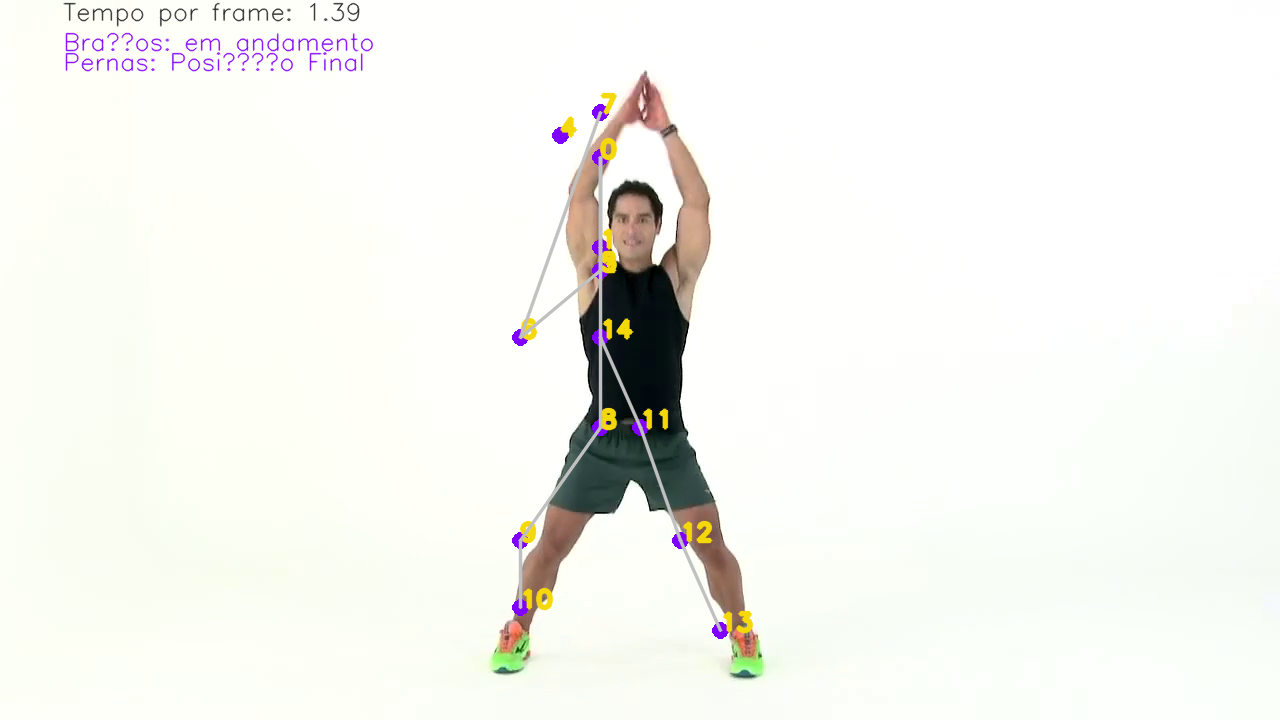

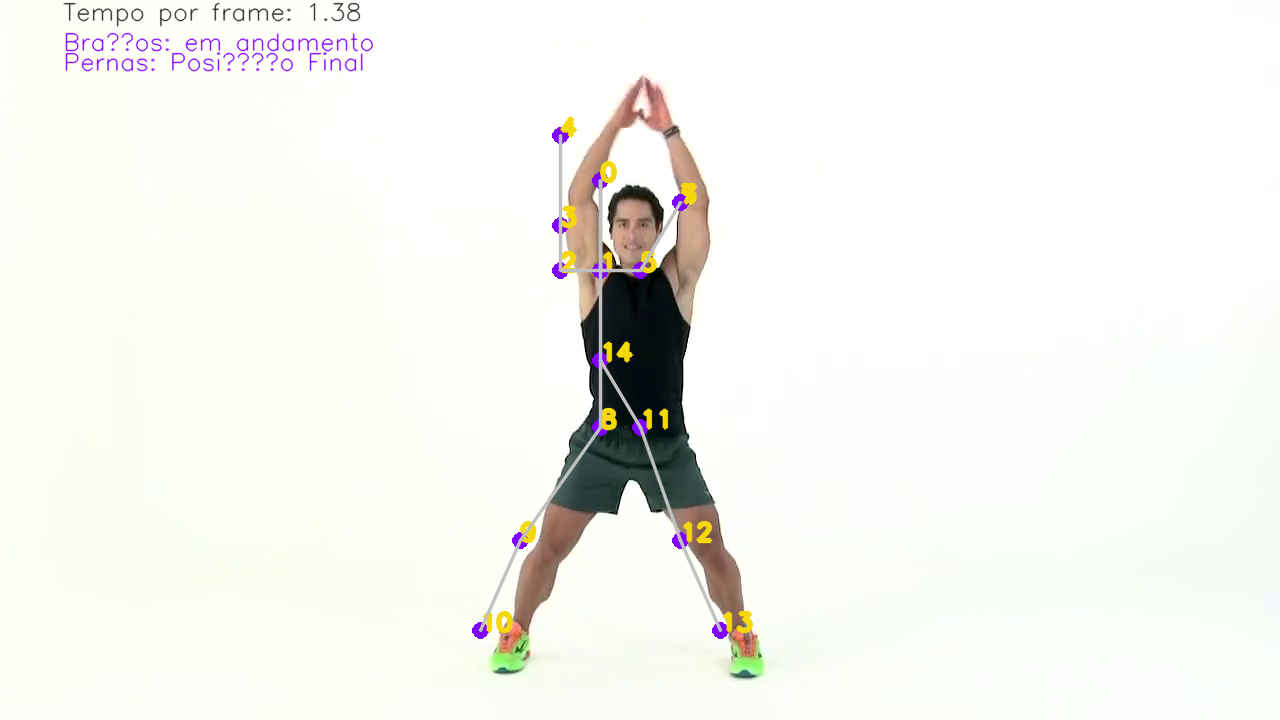

TypeError: 'NoneType' object is not subscriptable

In [ ]:
limite = 0.1
# while (cv2.waitKey(1) < 0): ## RODAR LOCAL
while True:
  t = time.time()
  conectado, video = captura.read()

  video_copia = np.copy(video)

  if not conectado:
    # cv2.waitKey() ## RODAR LOCAL
    break

  video_largura = video.shape[1]
  video_altura = video.shape[0]

  # Criação da mascara com fundo preto
  tamanho = cv2.resize(video, (video_largura, video_altura))
  mapa_suave = cv2.GaussianBlur(tamanho, (3,3), 0, 0)
  fundo = np.uint8(mapa_suave > limite)

  # Conversão do tipo da imagem OpenCVtoBlobCafe
  blob_entrada = cv2.dnn.blobFromImage(video, 1.0 / 255,
                                       (entrada_largura, entrada_altura),
                                       (0, 0, 0), swapRB = False, crop = False)

  modelo.setInput(blob_entrada)
  saida = modelo.forward()

  altura = saida.shape[2]
  largura = saida.shape[3]

  pontos = []

  for i in range(numero_pontos):
    mapa_confianca = saida[0, i, :, :]
    _, confianca, _, ponto = cv2.minMaxLoc(mapa_confianca)

    x = (video_largura * ponto[0]) / largura
    y = (video_altura * ponto[1]) / altura

    if confianca > limite:
      cv2.circle(video_copia, (int(x), int(y)), 4, cor_pontoB,
                 thickness = tamanho_circulo,
                 lineType = cv2.FILLED)
      cv2.putText(video_copia, "{}".format(i), (int(x), int(y)),
                  fonte, tamanho_fonte, cor_txtponto, 3,
                  lineType = cv2.LINE_AA)
      cv2.putText(fundo, " ", (int(x), int(y)),
                  fonte, tamanho_fonte, cor_txtponto, 3,
                  lineType = cv2.LINE_AA)
      pontos.append((int(x), int(y)))
    else:
      pontos.append(None)

  # Desenho do esqueleto
  for par in pares_pontos:
    parteA = par[0]
    parteB = par[1]

    if pontos[parteA] and pontos[parteB]:
      cv2.line(video, pontos[parteA], pontos[parteB], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
      cv2.line(video_copia, pontos[parteA], pontos[parteB], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
      cv2.line(fundo, pontos[parteA], pontos[parteB], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)

      cv2.circle(video, pontos[parteA], 4, cor_pontoA, thickness = espessura,
                 lineType = cv2.FILLED)
      cv2.circle(video, pontos[parteB], 4, cor_pontoA, thickness = espessura,
                 lineType = cv2.FILLED)

      cv2.circle(fundo, pontos[parteA], 4, cor_pontoA, thickness = espessura,
                 lineType = cv2.FILLED)
      cv2.circle(fundo, pontos[parteB], 4, cor_pontoA, thickness = espessura,
                 lineType = cv2.FILLED)
  # Braços
  if extrator_CORPO.verificar_bracos_ABAIXO(pontos[0:8]) == True:
    # 25% do movimento concluido
    valida_bracos_abaixo = 0.25
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Braços: Posição Inicial", (50, 50),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)

  elif extrator_CORPO.verificar_bracos_ACIMA(pontos[0:8]) == True:
    # 50% do movimento concluido
    valida_bracos_acima = 0.5
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Braços: Posição Final", (50, 50),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)
  else:
    valida_bracos_abaixo = 0
    valida_bracos_acima = 0
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Braços: em andamento", (50, 50),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)

  # Pernas
  if extrator_CORPO.verificar_pernas_AFASTADAS(pontos[8:14]) == True:
    # 50% do movimento
    valida_pernas_afastadas = 0.5
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Pernas: Posição Final", (50, 70),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)

  elif extrator_CORPO.verificar_pernas_JUNTAS(pontos[8:14]) == True:
    # 25% do movimento
    valida_pernas_juntas = 0.25
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Pernas: Posição Inicial", (50, 70),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)
  else:
    valida_pernas_juntas = 0
    valida_pernas_afastadas = 0
    cv2.line(video_copia, pontos[0], pontos[1], cor_linha,
               tamanho_linha, lineType = cv2.LINE_AA)
    cv2.putText(video_copia, " Pernas: em andamento", (50, 70),
                  fonte, tamanho_fonte, cor_txtinicial, 0,
                  lineType = cv2.LINE_AA)

  if valida_bracos_acima != 0 and valida_pernas_afastadas != 0:
    cv2.putText(video_copia, "Polichinelo valido: " + str(int(valida_bracos_acima
                                                              + valida_pernas_afastadas
                                                          )),
                  (50, 200), fonte, tamanho_fonte, cor_txtandamento, 0,
                  lineType = cv2.LINE_AA)

  cv2.putText(video_copia, " Tempo por frame: {:.2f}".format(time.time() - t) ,
                  (50, 20), fonte, tamanho_fonte, (40,40,40), 0,
                  lineType = cv2.LINE_AA)
  cv2_imshow(video_copia)
  # cv2_imshow(video)
  # cv2_imshow(fundo)
  # gravar_video.write(fundo)
  gravar_video.write(video_copia)
gravar_video.release()